In [1]:
import sys
import os 
%load_ext autoreload
%autoreload 2

os.chdir("/home/cooper-cooper/Desktop/vans/")

sys.path[0] = "/home/cooper-cooper/Desktop/vans/"


from utilities.variational import Autoencoder
import tensorflow_quantum as tfq
from utilities.qmodels import QNN,EnergyLoss

import tensorflow as tf

from utilities.evaluator import Evaluator
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
from utilities.variational import VQE
import cirq

from datetime import datetime

from utilities.variational import VQE
from utilities.evaluator import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer_autoencoder import UnitaryMurder
from utilities.misc import scheduler_selector_temperature, scheduler_parameter_perturbation_wall #this outputs always 10 for now.




In [2]:

### load pure states

indexed_pure_states=[]
resolver_pure_states=[]
train_bonds=[]
energsin=[]
js=np.linspace(0.5,2.3,16)[0::3]
fcisfull=np.load("results/autoencoder/H2/fcisfull.npy")
isok=[]
teners=[]
compis=[]
for bond in tqdm(js):
    problem_config ={"problem" : "H2", "geometry": str([('H', (0., 0., 0.)), ('H', (0., 0., bond))]).replace("\'",""), "multiplicity":1, "charge":0, "basis":"sto-3g"}
    args={"n_qubits":4,"problem_config":problem_config, "load_displaying":False}
    evaluator_load = Evaluator(args,loading=True, path="../data-vans/")
    #energies.append(evaluator.raw_history[len(list(evaluator.raw_history.keys()))-1][-1])
    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True, lr=0.01, epochs=10000, patience=1000)
    siro, cuener, indexed_circuit, resolver, bestener,low = evaluator_load.evolution[evaluator_load.get_best_iteration()]#evaluator_load.get_best_iteration()]

    indexed_pure_states.append(indexed_circuit)
    resolver_pure_states.append(resolver)
    teners.append(cuener)
    train_bonds.append(bond)

100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


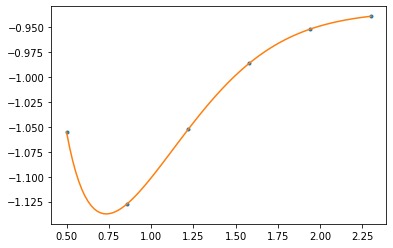

In [3]:
plt.plot(train_bonds,teners,'.')
plt.plot(np.linspace(.5,2.3,100),fcisfull)

In [4]:

auto_handler = Autoencoder(n_qubits=4,problem_config=problem_config, nb=2, lr = 0.01,
                        epochs=5000, verbose=0,
                        patience=200, optimizer="adam",
                        many_indexed_circuits=indexed_pure_states, many_symbols_to_values=resolver_pure_states)

au_evaluator = Evaluator(args={"n_qubits":4,
                            "problem_config":{"problem":"AutoencoderH2","n_qubits":len(auto_handler.qubits)},
                            "noise_config":{}},
                      info="", 
                      path="../data-vans/", acceptance_percentage=1e-7, reduce_acceptance_percentage=True)

info = "AUTOENCODEr\ntotal_qubits: {}\ntrash_qubits: {}\n".format(len(auto_handler.qubits), auto_handler.nb)
au_evaluator.displaying["information"]+=info


start = datetime.now()


selector_temperature=1
reps=50
rate_iids_per_step=1.5
wait_to_get_back=5

iid = IdInserter(n_qubits=len(auto_handler.qubits))
iid.selector_temperature = selector_temperature

#Simplifier reduces gates number as much as possible while keeping same expected value of target hamiltonian
Simp = Simplifier(n_qubits=len(auto_handler.qubits))

#UnitaryMuerder is in charge of evaluating changes on the energy while setting apart one (or more) parametrized gates. If
killer = UnitaryMurder(auto_handler, many_indexed_circuits=indexed_pure_states,
                       many_symbols_to_values=resolver_pure_states, noise_config={}, accept_wall=2/au_evaluator.acceptance_percentage)

#indexed_circuit = auto_handler.hea_ansatz_indexed_circuit(L=3)
inexed_circuit = [auto_handler.number_of_cnots+k for k in range(auto_handler.n_qubits,2*vqe_handler.n_qubits)]
print("beggining to train!")
energy, symbol_to_value, training_evolution = auto_handler.autoencoder(indexed_circuit) #compute energy
#add initial info to au_evaluator


to_print="\nIteration #{}\nTime since beggining:{}\n best energy: {}\ncurrent_energy {}\n lower_bound: {}".format(0, datetime.now()-start, energy, energy, au_evaluator.accuracy_to_end)
print(to_print)
au_evaluator.displaying["information"]+=to_print

au_evaluator.add_step(indexed_circuit, symbol_to_value, energy, relevant=True)
au_evaluator.lowest_energy = energy

for iteration in range(1,reps+1):
    relevant=False

    ### create a mutation M (maybe this word is too fancy); we add (probably more than one) identity resolution
    iid.selector_temperature=scheduler_selector_temperature(energy, au_evaluator.lowest_energy, when_on=selector_temperature)
    M_indices, M_symbols_to_values, M_idx_to_symbols = iid.place_identities(indexed_circuit, symbol_to_value, rate_iids_per_step= rate_iids_per_step)

    ### simplify the circuit as much as possible
    Sindices, Ssymbols_to_values, Sindex_to_symbols = Simp.reduce_circuit(M_indices, M_symbols_to_values, M_idx_to_symbols)

    ## compute the energy of the mutated-simplified circuit [Note 1]
    MSenergy, MSsymbols_to_values, _ = auto_handler.autoencoder(
        Sindices, symbols_to_values=Ssymbols_to_values,
        parameter_perturbation_wall=scheduler_parameter_perturbation_wall(its_without_improvig=au_evaluator.its_without_improvig))

    if au_evaluator.accept_energy(MSenergy):
        indexed_circuit, symbol_to_value, index_to_symbols = Sindices, MSsymbols_to_values, Sindex_to_symbols
        # unitary slaughter: delete as many 1-qubit gates as possible, as long as the energy doesn't go up (we allow %1 increments per iteration)
        cnt=0
        reduced=True
        lmax=len(indexed_circuit)
        while reduced and cnt < lmax:
            indexed_circuit, symbol_to_value, index_to_symbols, energy, reduced = killer.unitary_slaughter(indexed_circuit, symbol_to_value, index_to_symbols, reference_energy=MSenergy)
            indexed_circuit, symbol_to_value, index_to_symbols = Simp.reduce_circuit(indexed_circuit, symbol_to_value, index_to_symbols)
            cnt+=1
        relevant=True
    au_evaluator.add_step(indexed_circuit, symbol_to_value, energy, relevant=relevant)

    to_print="\nIteration #{}\nTime since beggining:{}\n best energy: {}\ncurrent energy: {}\n lower_bound: {}".format(iteration, datetime.now()-start, au_evaluator.lowest_energy,energy, au_evaluator.accuracy_to_end)
    print(to_print)
    au_evaluator.displaying["information"]+=to_print

    au_evaluator.save_dicts_and_displaying()

    if au_evaluator.if_finish_ok is True:
        print("HOMEWORK DONE! \nBeers on me ;)")
        break

    if au_evaluator.its_without_improvig == wait_to_get_back:
        print("Getting back to favorite, it's been already {} iterations".format(wait_to_get_back))
        _, energy, indices, resolver, _, _ =  au_evaluator.evolution[au_evaluator.get_best_iteration()]
        au_evaluator.its_without_improvig = 0


beggining to train!

Iteration #0
Time since beggining:0:00:03.943266
 best energy: 0.07271438837051392
current_energy 0.07271438837051392
 lower_bound: -inf
I killed 1 unitaries, Ef - Ei: 3.5762786865234375e-07

Iteration #1
Time since beggining:0:00:16.842731
 best energy: 5.167722702026367e-05
current energy: 5.167722702026367e-05
 lower_bound: -inf
I killed 1 unitaries, Ef - Ei: -6.556510925292969e-07
I killed 2 unitaries, Ef - Ei: -6.556510925292969e-07
I killed 3 unitaries, Ef - Ei: -6.556510925292969e-07
I killed 4 unitaries, Ef - Ei: -6.556510925292969e-07
I killed 5 unitaries, Ef - Ei: -6.556510925292969e-07
I killed 6 unitaries, Ef - Ei: -4.76837158203125e-07
I killed 7 unitaries, Ef - Ei: -6.556510925292969e-07
I killed 8 unitaries, Ef - Ei: -4.76837158203125e-07
I killed 9 unitaries, Ef - Ei: -1.7881393432617188e-07
I killed 10 unitaries, Ef - Ei: -2.980232238769531e-07
I killed 11 unitaries, Ef - Ei: -2.980232238769531e-07

Iteration #2
Time since beggining:0:02:27.408472


I killed 5 unitaries, Ef - Ei: -1.1920928955078125e-07
I killed 6 unitaries, Ef - Ei: -1.1920928955078125e-07

Iteration #28
Time since beggining:0:51:00.069007
 best energy: 5.960464477539063e-08
current energy: 5.960464477539063e-08
 lower_bound: -inf

Iteration #29
Time since beggining:0:51:04.636265
 best energy: 5.960464477539063e-08
current energy: 5.960464477539063e-08
 lower_bound: -inf

Iteration #30
Time since beggining:0:51:09.428298
 best energy: 5.960464477539063e-08
current energy: 5.960464477539063e-08
 lower_bound: -inf

Iteration #31
Time since beggining:0:51:14.589785
 best energy: 5.960464477539063e-08
current energy: 5.960464477539063e-08
 lower_bound: -inf

Iteration #32
Time since beggining:0:51:55.217918
 best energy: 5.960464477539063e-08
current energy: 5.960464477539063e-08
 lower_bound: -inf


/home/cooper-cooper/Desktop/vans/utilities/unitary_killer_autoencoder.py:123: RuntimeWarning: divide by zero encountered in float_scalars
  relative_error = (e_new-e_old)/np.abs(e_old)
/home/cooper-cooper/Desktop/vans/utilities/unitary_killer_autoencoder.py:123: RuntimeWarning: invalid value encountered in float_scalars
  relative_error = (e_new-e_old)/np.abs(e_old)


I killed 1 unitaries, Ef - Ei: 0.0
I killed 2 unitaries, Ef - Ei: -1.1920928955078125e-07
I killed 3 unitaries, Ef - Ei: 0.0
I killed 4 unitaries, Ef - Ei: -1.1920928955078125e-07
I killed 5 unitaries, Ef - Ei: 0.0
I killed 6 unitaries, Ef - Ei: 0.0
I killed 7 unitaries, Ef - Ei: 0.0
I killed 8 unitaries, Ef - Ei: 0.0

Iteration #33
Time since beggining:0:56:08.899603
 best energy: 0.0
current energy: 0.0
 lower_bound: -inf


/home/cooper-cooper/Desktop/vans/utilities/misc.py:17: RuntimeWarning: invalid value encountered in float_scalars
  relative_energy = np.abs((energy - lowest_energy_found)/lowest_energy_found)



Iteration #34
Time since beggining:0:56:19.373463
 best energy: 0.0
current energy: 0.0
 lower_bound: -inf

Iteration #35
Time since beggining:0:56:23.098031
 best energy: 0.0
current energy: 0.0
 lower_bound: -inf

Iteration #36
Time since beggining:0:56:35.241477
 best energy: 0.0
current energy: 0.0
 lower_bound: -inf

Iteration #37
Time since beggining:0:56:38.906521
 best energy: 0.0
current energy: 0.0
 lower_bound: -inf

Iteration #38
Time since beggining:0:56:54.245082
 best energy: 0.0
current energy: 0.0
 lower_bound: -inf
Getting back to favorite, it's been already 5 iterations

Iteration #39
Time since beggining:0:56:59.121228
 best energy: 0.0
current energy: 0.0
 lower_bound: -inf

Iteration #40
Time since beggining:0:57:04.345174
 best energy: 0.0
current energy: 0.0
 lower_bound: -inf

Iteration #41
Time since beggining:0:57:41.217444
 best energy: 0.0
current energy: 0.0
 lower_bound: -inf

Iteration #42
Time since beggining:0:57:45.857658
 best energy: 0.0
current en

In [56]:
WW, en, indexed_circuit, resolver, a,b =au_evaluator.raw_history[32]

In [57]:
inverse_indexed_circuit, inversolver, Wdagger = auto_handler.give_inverse(indexed_circuit,symbol_to_value)
Wdagger=cirq.unitary(Wdagger)

In [58]:

def compute_fidelity(input_state, encoding, channel, decoding):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.round(np.dot(np.conjugate(input_state),st), 16)

def compute_energy(input_state, encoding, channel, decoding, observable):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.dot(np.conjugate(st),np.dot(observable,st))


In [59]:
bond_train=np.linspace(0.5,2.3,16)[0::3]
bond_test=[]
test_energies = []
test_states=[]
train_energies=[]
fcis=[]
fcis_test=[]
eners=[]
fcis_train=[]
train_states=[]

batch_test = []
batch_train = []
for b in tqdm(np.linspace(0.5,2.3,16)):
    
    problem_config ={"problem" : "H2", "geometry": str([('H', (0., 0., 0.)), ('H', (0., 0., b))]).replace("\'",""), "multiplicity":1, "charge":0, "basis":"sto-3g"}
    args={"n_qubits":4,"problem_config":problem_config, "load_displaying":False}
    
    vqe_evaluator = Evaluator(args,loading=True, path="../data-vans/")

    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True, lr=0.01, epochs=4000,patience=400)
    
    siro, cuener, indexed_circuit, resolver, bestener,low = vqe_evaluator.evolution[vqe_evaluator.get_best_iteration()]#evaluator_load.get_best_iteration()]
    ene = cuener
    
    if not (b in bond_train):
        bond_test.append(b)
        test_energies.append(ene)
        fcis_test.append(vqe_handler.lower_bound_energy)
        test_states.append(cirq.unitary(siro)[:,0])
        
        batch_test.append(siro)
    else:
        train_states.append(cirq.unitary(siro)[:,0])
        train_energies.append(ene)
        fcis_train.append(vqe_handler.lower_bound_energy)
        batch_train.append(siro)


100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


In [62]:
from utilities.misc import give_kronecker_of_list
projector = give_kronecker_of_list([auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(auto_handler.nb)])
channel = np.kron(projector, np.eye(2**(auto_handler.n_qubits - auto_handler.nb)))

channel.shape

(16, 16)

In [63]:
ftest = [compute_fidelity(test_states[k], cirq.unitary(WW), channel, Wdagger) for k in range(len(test_states))]
ftrain = [compute_fidelity(test_states[k], cirq.unitary(WW), channel, Wdagger) for k in range(len(train_states))]

In [64]:
flotest = -np.log10(1-np.array(ftest))
flotrain = -np.log10(1-np.array(ftrain))

In [65]:
def give_q(a):
    return [np.mean(a), np.min(a), np.max(a)]

In [66]:
print(np.real(np.round(give_q(flotest),2)))

[0.33 0.24 0.4 ]


In [67]:
print(np.real(np.round(give_q(flotrain),2)))

[0.37 0.34 0.4 ]


In [68]:
1-np.array([np.mean(ftest), np.max(ftest), np.min(ftest)])

array([0.43466644+0.17925429j, 0.35568064+0.18429514j,
       0.55573916+0.1696254j ])

In [69]:
1-np.array([np.mean(ftrain), np.max(ftrain), np.min(ftrain)])

array([0.38096735+0.18280375j, 0.35568064+0.18429514j,
       0.42246543+0.18021419j])

/home/cooper-cooper/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


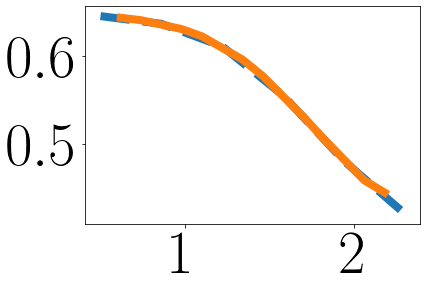

In [70]:
plt.plot(bond_train,np.real(list([compute_fidelity(train_states[k], cirq.unitary(WW), channel, Wdagger) for k in range(len(train_states))])),'--')
plt.plot(bond_test,[compute_fidelity(test_states[k], cirq.unitary(WW), channel, Wdagger) for k in range(len(test_states))])

In [71]:
things = au_evaluator.evolution[au_evaluator.get_best_iteration()]

model = QNN(symbols = list(things[3].keys()), observable=auto_handler.observable,batch_sizes=len(batch_train))
            
model.compile(loss=EnergyLoss(mode_var="autoencoder"))

In [72]:
import copy
pp = copy.deepcopy(batch_train)
for k in pp:
    k.append(things[0])
    
preds = model(tfq.convert_to_tensor(pp))
model.compiled_loss(preds,preds)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7881393e-07>

In [73]:
things = au_evaluator.evolution[au_evaluator.get_best_iteration()]

model = QNN(symbols = list(things[3].keys()), observable=auto_handler.observable,batch_sizes=len(batch_test))
            
model.compile(loss=EnergyLoss(mode_var="autoencoder"))

pp = copy.deepcopy(batch_test)
for k in pp:
    k.append(things[0])
    
preds = model(tfq.convert_to_tensor(pp))
model.compiled_loss(preds,preds)

<tf.Tensor: shape=(), dtype=float32, numpy=2.4974346e-05>

In [74]:
cost_value_test=[]
cost_value_train=[]

for ii in list(au_evaluator.evolution.values()):
    things = au_evaluator.evolution[au_evaluator.get_best_iteration()]
    model = QNN(symbols = list(things[3].keys()), observable=auto_handler.observable,batch_sizes=len(batch_test))
    model.compile(loss=EnergyLoss(mode_var="autoencoder"))

    pp = copy.deepcopy(batch_test)
    for k in pp:
        k.append(ii[0])

    preds = model(tfq.convert_to_tensor(pp))
    cost_value_test.append(model.compiled_loss(preds,preds))
    
    model1 = QNN(symbols = list(things[3].keys()), observable=auto_handler.observable,batch_sizes=len(batch_train))
    model1.compile(loss=EnergyLoss(mode_var="autoencoder"))
    
    ppo = copy.deepcopy(batch_train)
    for k in ppo:
        k.append(ii[0])

    preds = model1(tfq.convert_to_tensor(ppo))
    cost_value_train.append(model1.compiled_loss(preds,preds))

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


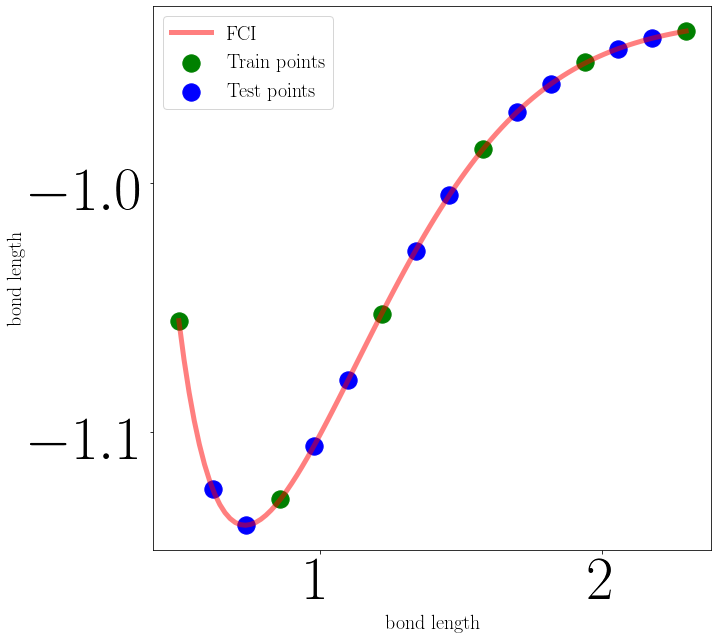

In [75]:
#fcisfull=[]
#for b in tqdm(np.linspace(0.5,2.3,100)):
#    problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., b))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
#    args={"n_qubits":8,"problem_config":problem_config, "load_displaying":False,"specific_folder_name":"4_bd_{}".format(b)}
#    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
#                            return_lower_bound=True)
#    fcisfull.append(vqe_handler.lower_bound_energy)
fcisfull=np.load("results/autoencoder/H2/fcisfull.npy")


plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.5,2.3,100),fcisfull,color="red",linewidth=5,alpha=0.5,label="FCI")

plt.scatter(bond_train, np.squeeze(train_energies),s=300, color="green",label="Train points")
plt.scatter(bond_test, np.squeeze(test_energies), s=300,color="blue",label="Test points")

#plt.scatter(bond_train, fcis_train,s=300, color="green",label="Train points")
#plt.scatter(bond_test, fcis_test, s=300,color="blue",label="Test points")
plt.xlabel("bond length",size=20)
plt.ylabel("bond length",size=20)
plt.legend(prop={"size":20})
#plt.savefig(fol+"energies.png")

In [76]:
nconts = []
nparams = []
cost_value=[]
for k in list(au_evaluator.evolution.values()):
    cost_value.append(k[1])
    nconts.append(au_evaluator.count_cnots(k[2]))
    nparams.append(au_evaluator.count_params(k[2]))    

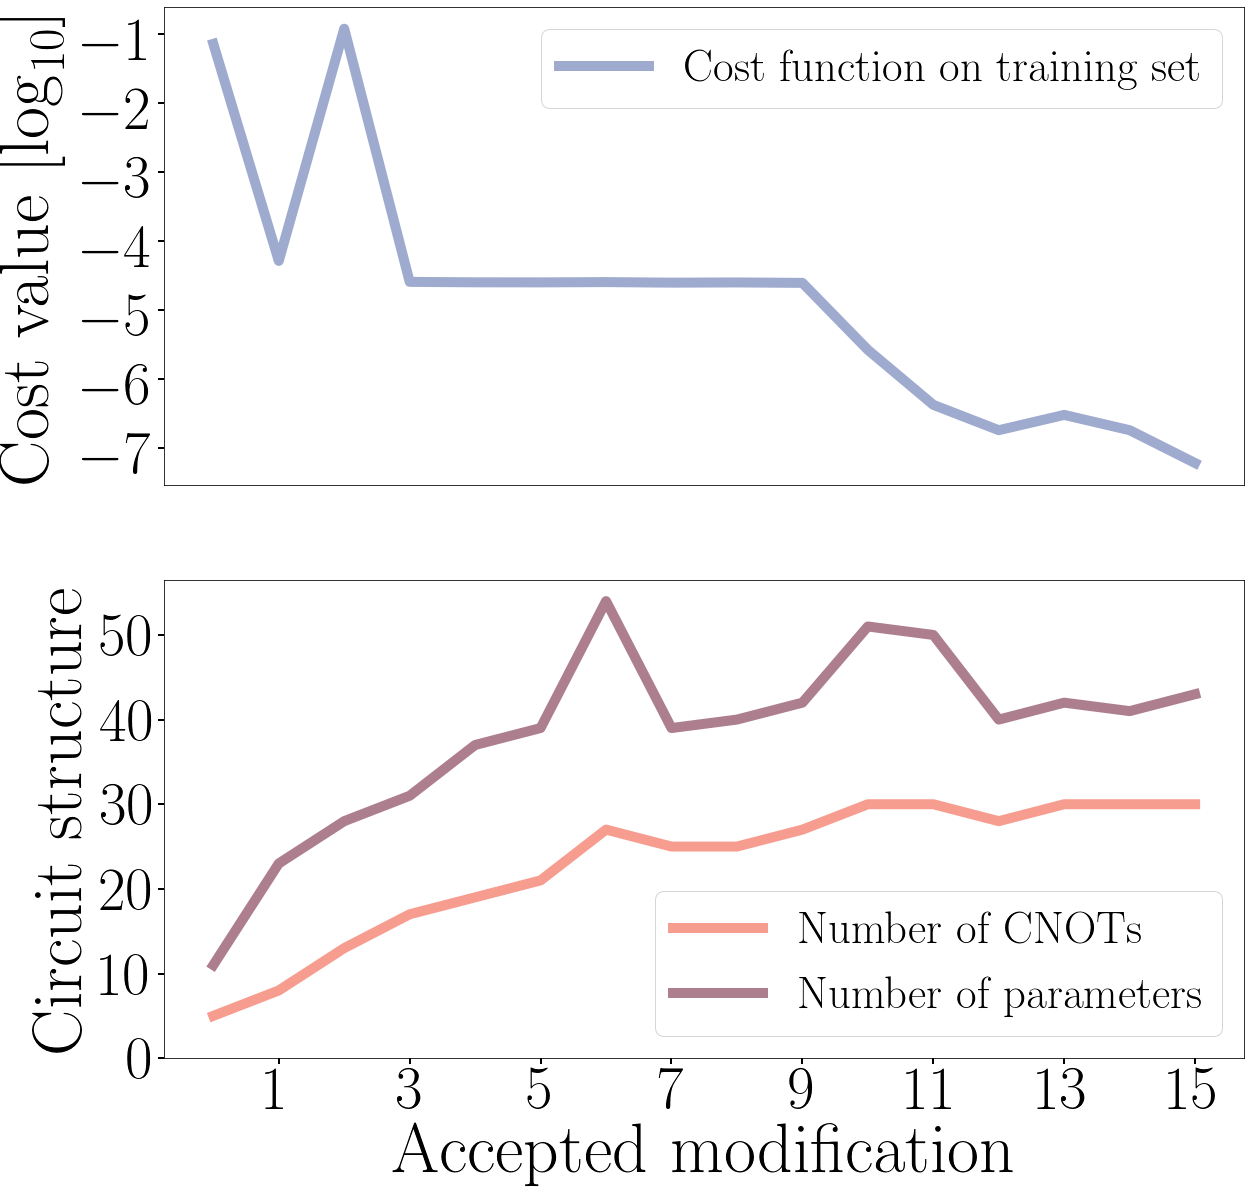

In [77]:

color1="#D79922"
color2="#4056A1"
color3="#F13C20"
color4="#5D001E"
color5="#8E8D8A"
import matplotlib

plt.style.use('results/plots/style.mplstyle')
matplotlib.rc("text",usetex=True)
plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.colors as colors
converter = colors.ColorConverter()
plt.rcParams.update({'font.size': 45})


plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom=0.15,left=0.15)
ax1,ax2 = [plt.subplot2grid((2,1),(k,0)) for k in range(2)]
ax1.plot(np.log10(cost_value_train),color=converter.to_rgb(color2),linewidth=10,alpha=0.5,label="Cost function on training set")
#ax1.plot(np.log10(cost_value_test),color=converter.to_rgb(color1),linewidth=10,alpha=0.5,label="Cost function on testing set")

ax1.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=60)
ax1.xaxis.set_visible(False)
#ax1.xlabel("Accepted modification")
ax1.set_ylabel("Cost value "+r'$[\log _{10}]$',size=70)
ax1.legend(prop={"size":45})

ax2.plot(nconts,color=converter.to_rgb(color3),linewidth=10,alpha=0.5,label="Number of CNOTs")
ax2.plot(nparams,color=converter.to_rgb(color4),linewidth=10,alpha=0.5,label="Number of parameters")
ax2.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=60)
ax2.set_xticks(range(1,len(cost_value_test), 2))
ax2.set_yticks(range(0,60,10))
ax1.set_yticks(np.arange(-7,0,1))

ax2.set_xlabel("Accepted modification",size=70)
ax2.set_ylabel("Circuit structure",size=70)
ax2.legend(prop={"size":45})

#plt.savefig("results/autoencoder/AE_numerics_12.pdf",format="pdf")

In [157]:
index_to_symbols = au_evaluator.give_circuit(ind)[-1]

In [154]:
symbol_to_value = 
indexed_circuit = ind
indexed_circuit, symbol_to_value, index_to_symbols = Simp.reduce_circuit(indexed_circuit, symbol_to_value, index_to_symbols)


KeyError: ''

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


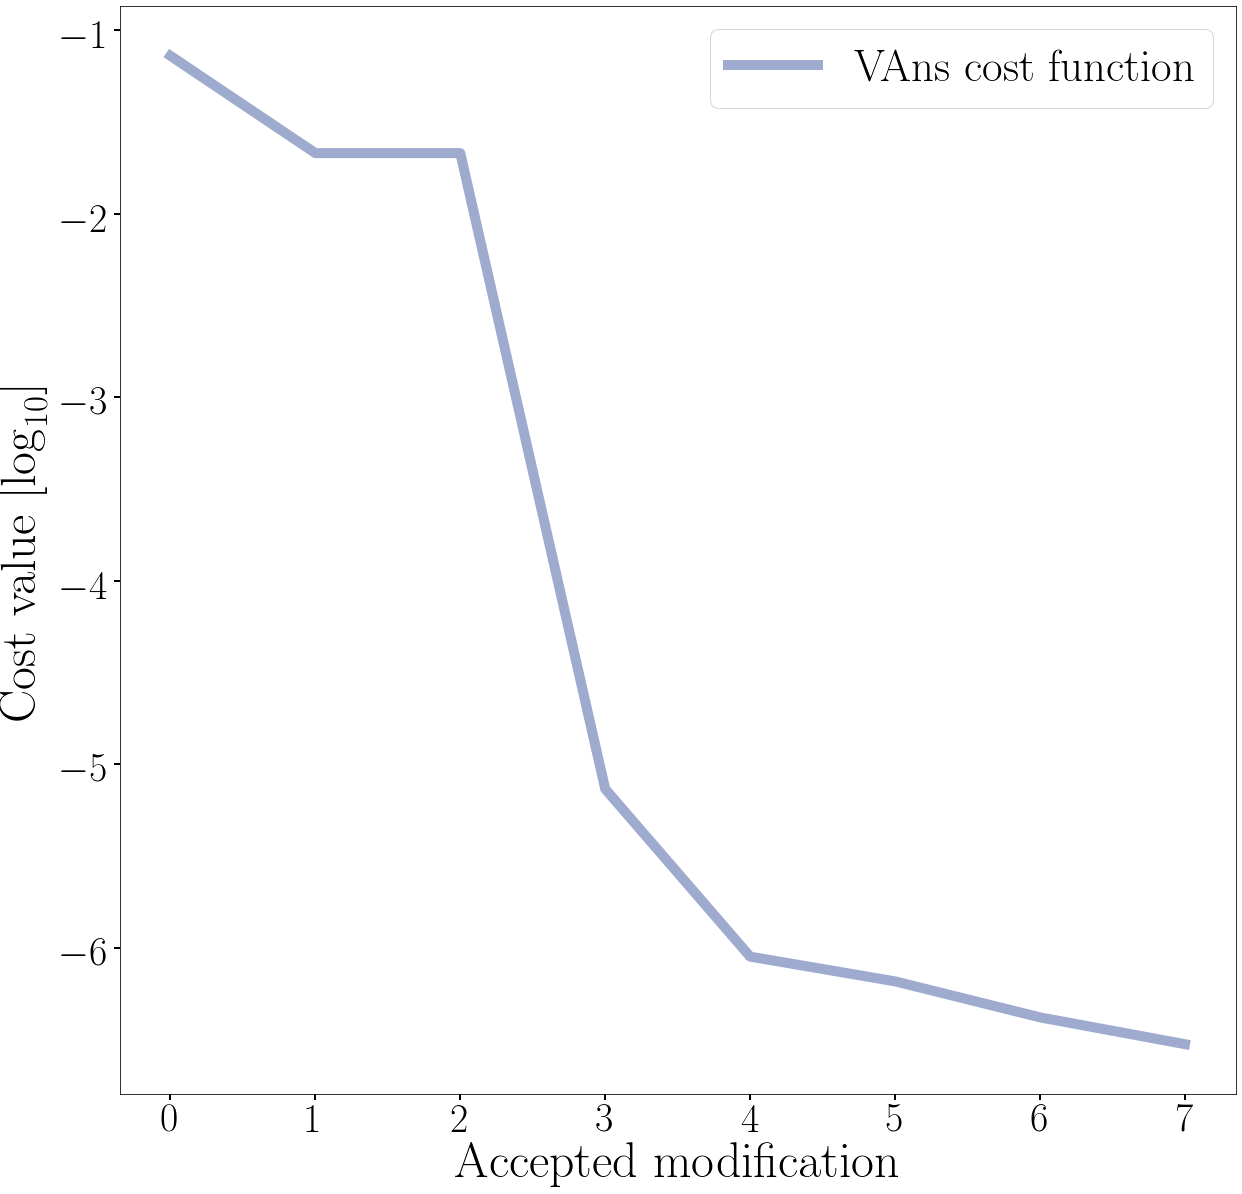

In [82]:

    

color1="#D79922"
color2="#4056A1"
color3="#F13C20"
color4="#5D001E"
color5="#8E8D8A"
import matplotlib

plt.style.use('results/plots/style.mplstyle')
matplotlib.rc("text",usetex=True)
plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.colors as colors
converter = colors.ColorConverter()
plt.rcParams.update({'font.size': 45})


plt.figure(figsize=(20,20))
plt.plot(np.log10(cost_value),color=converter.to_rgb(color2),linewidth=10,alpha=0.5,label="VAns cost function")
plt.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=40)
#plt.xticks([0.5,2.0,1.0,1.5,2.0,2.3])
plt.xlabel("Accepted modification")
plt.ylabel("Cost value "+r'$[\log _{10}]$')
plt.legend(prop={"size":45})
#plt.savefig("cost_value_separable.pdf",format="pdf")

Let's check fidelities in both train and test set

In [ ]:
vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                        return_lower_bound=True)
VAnsCircuit, cuener, indexed_circuit, resolver, bestener = vqe_evaluator.evolution[vqe_evaluator.get_best_iteration()]

model = QNN(symbols=list(resolver.keys()), observable=vqe_handler.observable, batch_sizes=1)
model.compile(loss=EnergyLoss())


In [ ]:
model.trainable_variables[0].assign(np.array(list(resolver.values())))

In [ ]:
things = auto_evaluator.evolution[auto_evaluator.get_best_iteration()]

In [ ]:
things[1]

In [ ]:
#### CHECK AT TRAIN FIDELITIES

fidelities = []
for k in range(len(auto_handler.qbatch)):
    input_state = cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
    fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
fidelities

In [ ]:
#### CHECK AT TRAIN FIDELITIES

fidelities = []
for k in test_states:
    input_state = k#cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
    fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
fidelities

In [ ]:
#### CHECK AT TRAIN FIDELITIES

fidelities = []
for k in train_states:
    input_state = k#cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
    fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
fidelities

In [ ]:
st =np.dot(cirq.unitary(W),train_states[0])

In [ ]:
b=0.5
problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., b))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
  
vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True)

In [ ]:
def compute_energy(input_state, encoding, channel, decoding, observable):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.dot(np.conjugate(st),np.dot(observable,st))

channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
ene=compute_energy(cirq.unitary(VAnsCircuit)[:,0], cirq.unitary(W), channel, Wdagger, sum(vqe_handler.observable).matrix())   
print(ene,cuener)

In [ ]:
b=0.5
problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., b))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
args={"n_qubits":8,"problem_config":problem_config, "load_displaying":False,"specific_folder_name":"4_bd_{}".format(b)}
vqe_evaluator = Evaluator(args,loading=True, path="../data-vans/data-in-paper-2marzo/")

vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                        return_lower_bound=True)
VAnsCircuit, cuener, indexed_circuit, resolver, bestener = vqe_evaluator.evolution[vqe_evaluator.get_best_iteration()]


In [ ]:
projector = give_kronecker_of_list([auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(auto_handler.nb)])
channel = np.kron(projector, np.eye(4))
compute_energy(cirq.unitary(VAnsCircuit)[:,0],cirq.unitary(W), channel, Wdagger, sum(vqe_handler.observable).matrix())

In [ ]:
compute_fidelity(cirq.unitary(VAnsCircuit)[:,0], cirq.unitary(W), channel, Wdagger)

In [ ]:
test_fidelities = []
for k in test_states:
    input_state = k#cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qbits[k]).matrix() for k in range(2)]), np.eye(4)))
    test_fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
test_fidelities

In [ ]:
train_fidelities = []
for k in train_states:
    input_state = k#cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
    train_fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
train_fidelities

In [ ]:
channel = np.eye(2**len(auto_handler.qubits)) - (1/auto_handler.nb)*(np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))

test_fidelities = []
for state in test_states:
    test_fidelities.append(compute_fidelity(state, W, channel, Wdagger))
    
train_fidelities = []
for state in train_states:
    train_fidelities.append(compute_fidelity(state, W, channel, Wdagger))

In [ ]:
import os 
fol="results/autoencoder/H2/"
os.makedirs(fol,exist_ok=True)
sts=["fcis_train", "fcis_test", "bond_train","bond_test", "bonds", "test_fidelities", "train_fidelities","fcisfull"]
fis=[fcis_train, fcis_test, bond_train, bond_test,np.linspace(0.5,2.3,16), test_fidelities, train_fidelities,fcisfull]
for strfi, thi in zip(sts, fis):
    np.save(fol+strfi,thi)

In [ ]:
bonds=np.linspace(0.5,2.3,16)
plt.figure(figsize=(10,10))
plt.plot(bonds,np.ones(len(bonds)),color="black",alpha=0.5,label="1")
plt.scatter(bond_train, train_fidelities, color="red",label="Train points")
plt.scatter(bond_test, test_fidelities, color="green",label="Test points")
plt.xlabel("bond length",size=20)
plt.ylabel("bond length",size=20)
plt.legend(prop={"size":20})
plt.savefig("fidelities.png")